### Amir Salman (msds18052)
### Fine-tuning VGG16 and RESNET18 on COVID19 dataset

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### APIs: Replacing olf FC Layers with 2 New Layers

In [0]:
def get_updated_features(fc_layer1_in_features):
  ROLL_NO = 52 # 18052
  fc_layer1_out_features = (ROLL_NO * 10) + 100

  new_features = []

  new_features.extend([nn.Linear(fc_layer1_in_features, fc_layer1_out_features)])
  new_features.extend([nn.ReLU(inplace=True)])
  new_features.extend([nn.Dropout(p=0.5, inplace=False)])
  new_features.extend([nn.Linear(fc_layer1_out_features, len(class_names))])

  return new_features

### APIs: Plotting Training and Validation Curves for Accuracy and Loss

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img
%matplotlib inline

def plot_loss_and_acc_curves(epochs, training_accuracy, training_loss, validation_accuracy, validation_loss):
  val_data_available = False
  if len(validation_accuracy) > 0:
    val_data_available = True
  fig_size = (12, 5)
  fig, axes = plt.subplots(1, 2, figsize=fig_size)
  x = np.arange(epochs)
  axes[0].plot(x, training_accuracy, color='red', label='Training Accuracy')
  if val_data_available:
    axes[0].plot(x, validation_accuracy, color='blue', label='Validation Accuracy')
  axes[0].set_title("Accuracy")
  axes[0].set_xlabel("Epochs")
  axes[0].legend()

  axes[1].plot(x, training_loss, color='red', label='Training Loss')
  if val_data_available:
    axes[1].plot(x, validation_loss, color='blue', label='Validation Loss')
  axes[1].set_title("Error/Loss")
  axes[1].set_xlabel("Epochs")
  axes[1].legend()

### APIs: Confusion Matrix, Accuracy and F1-Score

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def display_model_evaluation_parameters(model, loader, datatype):
  dataiter = iter(loader)
  images, labels = dataiter.next()

  correct = 0
  total = 0
  ground_truth = []
  predicted_labels = []
  with torch.no_grad():
      for data in loader:        
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          for i in predicted:
            predicted_labels.append(i.item())
          for i in labels:
            ground_truth.append(i.item())
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('%s Accuracy of the network on the %d images: %d %%' % (datatype, total, 
      100 * correct / total))

  f1 = f1_score(ground_truth, predicted_labels)
  print('%s F1 score: %f' % (datatype, f1))

  matrix = confusion_matrix(ground_truth, predicted_labels)

  print("%s Confusion Matrix" % (datatype))
  plt.figure()
  plt.matshow(matrix)
  plt.colorbar()
  plt.title(datatype + " Confusion Matrix")
  plt.ylabel('True Label')
  plt.xlabel('Predicated Label')
  plt.show()

### Saved Models Path

In [0]:
# Change this path if models are stored elsewhere
save_models_path = "./gdrive/My Drive/Assignment 5/SavedModels/"

### Load Dataset usign torchvision image loader

In [5]:
from google.colab import drive
drive.mount("./gdrive")
!unzip './gdrive/My Drive/Assignment 5/Assignment 5 Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

### Path for un-zipped dataset

In [0]:
data_dir = "/content/Assignment 5 Dataset"

In [7]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(size=224, scale=(0.9,1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.RandomResizedCrop(size=224, scale=(0.9,1.0)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.RandomResizedCrop(size=224, scale=(0.9,1.0)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=50, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


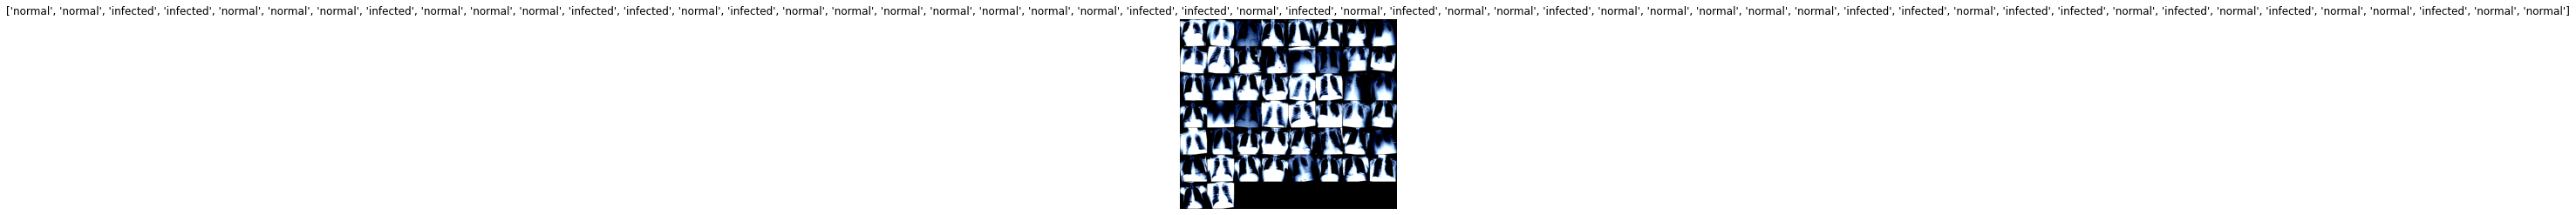

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# TASK 1

### Load pre-trained VGG-16

In [6]:
# Load the pretrained model from pytorch
model = models.vgg16(pretrained=True)
print(model)
print('Output Layer of VGG16 : ', model.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### Freezing all the Convolution Layers

In [0]:
for param in model.features.parameters():
    param.require_grad = False

### Replacing old FC Layers with 2 New FC Layers

In [0]:
new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss Function, Optimizer and Training

In [26]:
# Loss function and Optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    # counter = 0
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # counter = counter + 1
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_train_loss += loss.item()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct_count += (predicted == labels).sum().item()
        
        # if counter >= 5:
        #   break

    val_total = 0
    # counter = 0
    with torch.no_grad():
      for data in validationloader:  
          # counter = counter + 1        
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct_count += (predicted == labels).sum().item()

          loss = criterion(outputs, labels)   #----> compute loss
          running_val_loss += loss.item()

          # if counter >= 5:
          #   break;

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)

print('Finished Training')
print(training_loss)
print(training_accuracy)















0it [00:00, ?it/s]













1it [00:03,  3.36s/it]













2it [00:06,  3.40s/it]













3it [00:10,  3.37s/it]













4it [00:13,  3.35s/it]













5it [00:16,  3.33s/it]













6it [00:20,  3.33s/it]













7it [00:23,  3.32s/it]













8it [00:26,  3.32s/it]













9it [00:29,  3.30s/it]













10it [00:33,  3.29s/it]













11it [00:36,  3.29s/it]













12it [00:39,  3.30s/it]













13it [00:43,  3.39s/it]













14it [00:46,  3.37s/it]













15it [00:50,  3.36s/it]













16it [00:53,  3.34s/it]













17it [00:56,  3.32s/it]













18it [00:59,  3.32s/it]













19it [01:03,  3.31s/it]













20it [01:06,  3.32s/it]













21it [01:09,  3.32s/it]













22it [01:13,  3.32s/it]













23it [01:16,  3.31s/it]













24it [01:19,  3.30s/it]













25it [01:23,  3.31s/it]













26it [01:26,  3.32s/it]













2

Epoch = 0, accuracy = 0.926833, error = 50.978014
















1it [00:03,  3.22s/it]













2it [00:06,  3.22s/it]













3it [00:09,  3.23s/it]













4it [00:12,  3.22s/it]













5it [00:16,  3.21s/it]













6it [00:19,  3.20s/it]













7it [00:22,  3.25s/it]













8it [00:25,  3.23s/it]













9it [00:28,  3.21s/it]













10it [00:32,  3.25s/it]













11it [00:35,  3.23s/it]













12it [00:38,  3.22s/it]













13it [00:41,  3.20s/it]













14it [00:45,  3.19s/it]













15it [00:48,  3.19s/it]













16it [00:51,  3.19s/it]













17it [00:54,  3.19s/it]













18it [00:57,  3.18s/it]













19it [01:00,  3.17s/it]













20it [01:04,  3.17s/it]













21it [01:07,  3.16s/it]













22it [01:10,  3.16s/it]













23it [01:13,  3.20s/it]













24it [01:16,  3.18s/it]













25it [01:19,  3.17s/it]













26it [01:23,  3.17s/it]













27it [01:26,  3.16s/it]











Epoch = 1, accuracy = 0.939583, error = 41.322990
















1it [00:03,  3.13s/it]













2it [00:06,  3.13s/it]













3it [00:09,  3.13s/it]













4it [00:12,  3.14s/it]













5it [00:15,  3.14s/it]













6it [00:18,  3.14s/it]













7it [00:21,  3.14s/it]













8it [00:25,  3.14s/it]













9it [00:28,  3.16s/it]













10it [00:31,  3.15s/it]













11it [00:34,  3.15s/it]













12it [00:37,  3.15s/it]













13it [00:40,  3.15s/it]













14it [00:44,  3.15s/it]













15it [00:47,  3.14s/it]













16it [00:50,  3.14s/it]













17it [00:53,  3.14s/it]













18it [00:56,  3.15s/it]













19it [00:59,  3.14s/it]













20it [01:02,  3.14s/it]













21it [01:05,  3.14s/it]













22it [01:09,  3.14s/it]













23it [01:12,  3.13s/it]













24it [01:15,  3.13s/it]













25it [01:18,  3.15s/it]













26it [01:21,  3.14s/it]













27it [01:24,  3.14s/it]











Epoch = 2, accuracy = 0.949167, error = 38.494407
















1it [00:03,  3.16s/it]













2it [00:06,  3.24s/it]













3it [00:09,  3.21s/it]













4it [00:12,  3.19s/it]













5it [00:16,  3.17s/it]













6it [00:19,  3.16s/it]













7it [00:22,  3.15s/it]













8it [00:25,  3.15s/it]













9it [00:28,  3.14s/it]













10it [00:31,  3.14s/it]













11it [00:34,  3.13s/it]













12it [00:37,  3.14s/it]













13it [00:41,  3.14s/it]













14it [00:44,  3.13s/it]













15it [00:47,  3.13s/it]













16it [00:50,  3.13s/it]













17it [00:53,  3.13s/it]













18it [00:56,  3.13s/it]













19it [00:59,  3.13s/it]













20it [01:02,  3.13s/it]













21it [01:06,  3.12s/it]













22it [01:09,  3.14s/it]













23it [01:12,  3.16s/it]













24it [01:15,  3.16s/it]













25it [01:18,  3.15s/it]













26it [01:21,  3.14s/it]













27it [01:24,  3.14s/it]











Epoch = 3, accuracy = 0.951250, error = 35.572913
















1it [00:03,  3.14s/it]













2it [00:06,  3.15s/it]













3it [00:09,  3.13s/it]













4it [00:12,  3.13s/it]













5it [00:15,  3.13s/it]













6it [00:18,  3.12s/it]













7it [00:21,  3.12s/it]













8it [00:25,  3.12s/it]













9it [00:28,  3.13s/it]













10it [00:31,  3.14s/it]













11it [00:34,  3.13s/it]













12it [00:37,  3.13s/it]













13it [00:40,  3.17s/it]













14it [00:43,  3.15s/it]













15it [00:47,  3.14s/it]













16it [00:50,  3.14s/it]













17it [00:53,  3.13s/it]













18it [00:56,  3.18s/it]













19it [00:59,  3.17s/it]













20it [01:02,  3.15s/it]













21it [01:05,  3.14s/it]













22it [01:09,  3.14s/it]













23it [01:12,  3.21s/it]













24it [01:15,  3.19s/it]













25it [01:18,  3.16s/it]













26it [01:21,  3.14s/it]













27it [01:24,  3.13s/it]











Epoch = 4, accuracy = 0.954333, error = 32.940331
















0it [00:00, ?it/s]













1it [00:03,  3.13s/it]













2it [00:06,  3.14s/it]













3it [00:09,  3.14s/it]













4it [00:12,  3.13s/it]













5it [00:15,  3.13s/it]













6it [00:18,  3.13s/it]













7it [00:21,  3.13s/it]













8it [00:25,  3.13s/it]













9it [00:28,  3.13s/it]













10it [00:31,  3.14s/it]













11it [00:34,  3.14s/it]













12it [00:37,  3.14s/it]













13it [00:40,  3.13s/it]













14it [00:43,  3.14s/it]













15it [00:47,  3.14s/it]













16it [00:50,  3.13s/it]













17it [00:53,  3.14s/it]













18it [00:56,  3.14s/it]













19it [00:59,  3.14s/it]













20it [01:02,  3.13s/it]













21it [01:05,  3.13s/it]













22it [01:08,  3.13s/it]













23it [01:12,  3.12s/it]













24it [01:15,  3.13s/it]













25it [01:18,  3.15s/it]













26it [01:21,  3.14s/it]













2

Epoch = 5, accuracy = 0.956000, error = 32.091593
















1it [00:03,  3.15s/it]













2it [00:06,  3.12s/it]













3it [00:09,  3.10s/it]













4it [00:12,  3.09s/it]













5it [00:15,  3.07s/it]













6it [00:18,  3.09s/it]













7it [00:21,  3.08s/it]













8it [00:24,  3.08s/it]













9it [00:27,  3.07s/it]













10it [00:30,  3.07s/it]













11it [00:33,  3.07s/it]













12it [00:36,  3.06s/it]













13it [00:39,  3.05s/it]













14it [00:42,  3.06s/it]













15it [00:45,  3.05s/it]













16it [00:49,  3.06s/it]













17it [00:52,  3.05s/it]













18it [00:55,  3.06s/it]













19it [00:58,  3.07s/it]













20it [01:01,  3.08s/it]













21it [01:04,  3.07s/it]













22it [01:07,  3.07s/it]













23it [01:10,  3.07s/it]













24it [01:13,  3.07s/it]













25it [01:16,  3.06s/it]













26it [01:19,  3.06s/it]













27it [01:22,  3.12s/it]











Epoch = 6, accuracy = 0.960083, error = 29.357645
















1it [00:02,  2.97s/it]













2it [00:06,  3.01s/it]













3it [00:09,  3.00s/it]













4it [00:12,  3.01s/it]













5it [00:15,  3.07s/it]













6it [00:18,  3.06s/it]













7it [00:21,  3.04s/it]













8it [00:24,  3.03s/it]













9it [00:27,  3.01s/it]













10it [00:30,  3.00s/it]













11it [00:33,  3.00s/it]













12it [00:36,  3.00s/it]













13it [00:39,  2.98s/it]













14it [00:42,  2.98s/it]













15it [00:45,  2.99s/it]













16it [00:48,  3.00s/it]













17it [00:51,  2.99s/it]













18it [00:54,  2.99s/it]













19it [00:57,  3.00s/it]













20it [01:00,  3.00s/it]













21it [01:03,  2.99s/it]













22it [01:06,  3.03s/it]













23it [01:09,  3.02s/it]













24it [01:12,  3.02s/it]













25it [01:15,  3.01s/it]













26it [01:18,  3.01s/it]













27it [01:21,  3.00s/it]











Epoch = 7, accuracy = 0.960833, error = 28.784016
















1it [00:03,  3.00s/it]













2it [00:06,  3.03s/it]













3it [00:09,  3.02s/it]













4it [00:12,  3.02s/it]













5it [00:15,  3.01s/it]













6it [00:18,  3.04s/it]













7it [00:21,  3.03s/it]













8it [00:24,  3.04s/it]













9it [00:27,  3.03s/it]













10it [00:30,  3.02s/it]













11it [00:33,  3.02s/it]













12it [00:36,  3.01s/it]













13it [00:39,  3.01s/it]













14it [00:42,  3.00s/it]













15it [00:45,  2.99s/it]













16it [00:48,  2.99s/it]













17it [00:51,  2.98s/it]













18it [00:54,  2.99s/it]













19it [00:57,  2.99s/it]













20it [01:00,  2.99s/it]













21it [01:03,  2.98s/it]













22it [01:06,  2.99s/it]













23it [01:09,  2.98s/it]













24it [01:12,  3.07s/it]













25it [01:15,  3.05s/it]













26it [01:18,  3.04s/it]













27it [01:21,  3.02s/it]











Epoch = 8, accuracy = 0.965333, error = 26.557168
















1it [00:03,  3.06s/it]













2it [00:06,  3.06s/it]













3it [00:09,  3.07s/it]













4it [00:12,  3.07s/it]













5it [00:15,  3.04s/it]













6it [00:18,  3.02s/it]













7it [00:21,  3.02s/it]













8it [00:24,  3.01s/it]













9it [00:27,  3.01s/it]













10it [00:30,  3.00s/it]













11it [00:33,  3.00s/it]













12it [00:36,  3.02s/it]













13it [00:39,  3.01s/it]













14it [00:42,  3.01s/it]













15it [00:45,  3.00s/it]













16it [00:48,  3.00s/it]













17it [00:51,  3.00s/it]













18it [00:54,  3.00s/it]













19it [00:57,  3.01s/it]













20it [01:00,  3.00s/it]













21it [01:03,  3.00s/it]













22it [01:06,  2.99s/it]













23it [01:09,  3.00s/it]













24it [01:12,  3.00s/it]













25it [01:15,  3.02s/it]













26it [01:18,  3.02s/it]













27it [01:21,  3.02s/it]











Epoch = 9, accuracy = 0.965000, error = 25.880161
Finished Training
[50.97801377996802, 41.32299028709531, 38.49440682306886, 35.57291288115084, 32.94033136218786, 32.09159259777516, 29.357645463198423, 28.784015958197415, 26.55716808559373, 25.880161007866263]
[0.9268333333333333, 0.9395833333333333, 0.9491666666666667, 0.95125, 0.9543333333333334, 0.956, 0.9600833333333333, 0.9608333333333333, 0.9653333333333334, 0.965]


### Save the Model VGG16

In [0]:
torch.save(model.state_dict(), saved_models_path + 'vgg16_FC_Only.pth')

### Accuracy and Loss Curves during Training

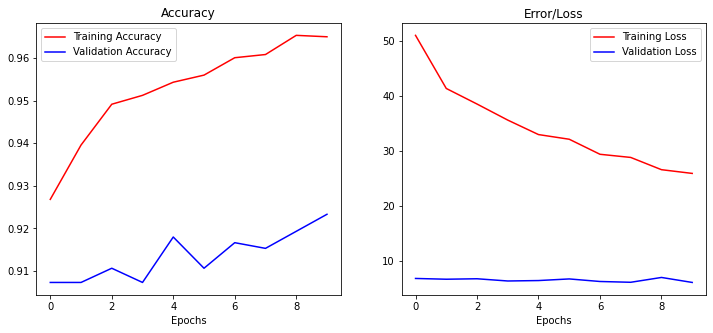

In [28]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 96 %
Training F1 score: 0.970932
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

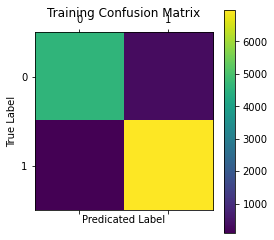

Testing Accuracy of the network on the 1500 images: 97 %
Testing F1 score: 0.978771
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

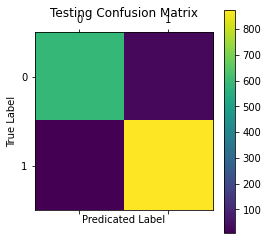

Validation Accuracy of the network on the 1500 images: 91 %
Validation F1 score: 0.931705
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

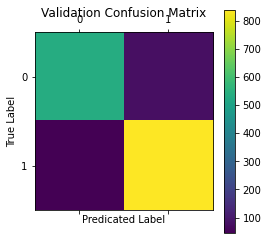

In [33]:
display_model_evaluation_parameters(model, trainloader, "Training")
display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")

### Evaluation: Load and Test my pre-trained VGG-16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<Figure size 432x288 with 0 Axes>

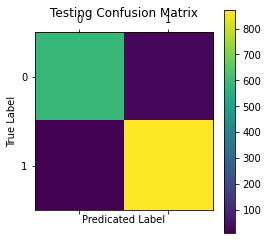

In [22]:
# Load the pretrained model from pytorch
PATH = saved_models_path + 'vgg16_FC_Only.pth'
model = models.vgg16(pretrained=False)
new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")

### Load pre-trained RESNET18

In [34]:
# Load the pretrained model from pytorch
model = models.resnet18(pretrained=True)
print(model)
print('Output Layer of RESNET18 : ', model.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freezing all the Convolution Layers

In [0]:
for param in model.conv1.parameters():
    param.require_grad = False
for param in model.bn1.parameters():
    param.require_grad = False
for param in model.relu.parameters():
    param.require_grad = False
for param in model.maxpool.parameters():
    param.require_grad = False
for param in model.layer1.parameters():
    param.require_grad = False
for param in model.layer2.parameters():
    param.require_grad = False
for param in model.layer3.parameters():
    param.require_grad = False
for param in model.layer4.parameters():
    param.require_grad = False
for param in model.avgpool.parameters():
    param.require_grad = False

### Replacing old FC Layers with 2 New FC Layers

In [39]:
new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss Function, Optimizer and Training

In [40]:
# Loss function and Optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    # counter = 0
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_train_loss += loss.item()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct_count += (predicted == labels).sum().item()
        
    val_total = 0
    with torch.no_grad():
      for data in validationloader:  
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct_count += (predicted == labels).sum().item()

          loss = criterion(outputs, labels)   #----> compute loss
          running_val_loss += loss.item()

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)

print('Finished Training')
print(training_loss)
print(training_accuracy)


0it [00:00, ?it/s]
1it [00:01,  1.88s/it]
2it [00:03,  1.86s/it]
3it [00:05,  1.90s/it]
4it [00:07,  1.85s/it]
5it [00:09,  1.81s/it]
6it [00:10,  1.79s/it]
7it [00:12,  1.77s/it]
8it [00:14,  1.76s/it]
9it [00:16,  1.74s/it]
10it [00:17,  1.74s/it]
11it [00:19,  1.73s/it]
12it [00:21,  1.74s/it]
13it [00:22,  1.73s/it]
14it [00:24,  1.74s/it]
15it [00:26,  1.80s/it]
16it [00:28,  1.79s/it]
17it [00:30,  1.81s/it]
18it [00:32,  1.89s/it]
19it [00:34,  1.92s/it]
20it [00:36,  1.85s/it]
21it [00:37,  1.80s/it]
22it [00:39,  1.78s/it]
23it [00:41,  1.75s/it]
24it [00:42,  1.74s/it]
25it [00:44,  1.74s/it]
26it [00:46,  1.81s/it]
27it [00:48,  1.78s/it]
28it [00:49,  1.76s/it]
29it [00:51,  1.76s/it]
30it [00:53,  1.75s/it]
31it [00:55,  1.74s/it]
32it [00:57,  1.77s/it]
33it [00:58,  1.76s/it]
34it [01:00,  1.80s/it]
35it [01:02,  1.77s/it]
36it [01:04,  1.75s/it]
37it [01:05,  1.73s/it]
38it [01:07,  1.75s/it]
39it [01:09,  1.75s/it]
40it [01:11,  1.74s/it]
41it [01:12,  1.74s/it]
42it 

Epoch = 0, accuracy = 0.864917, error = 78.089470



1it [00:01,  1.92s/it]
2it [00:03,  1.84s/it]
3it [00:05,  1.78s/it]
4it [00:06,  1.73s/it]
5it [00:08,  1.69s/it]
6it [00:10,  1.67s/it]
7it [00:11,  1.67s/it]
8it [00:13,  1.66s/it]
9it [00:14,  1.65s/it]
10it [00:16,  1.64s/it]
11it [00:18,  1.63s/it]
12it [00:19,  1.63s/it]
13it [00:21,  1.62s/it]
14it [00:23,  1.62s/it]
15it [00:24,  1.62s/it]
16it [00:26,  1.62s/it]
17it [00:27,  1.62s/it]
18it [00:29,  1.63s/it]
19it [00:31,  1.63s/it]
20it [00:32,  1.64s/it]
21it [00:34,  1.64s/it]
22it [00:36,  1.63s/it]
23it [00:37,  1.64s/it]
24it [00:39,  1.63s/it]
25it [00:41,  1.63s/it]
26it [00:42,  1.62s/it]
27it [00:44,  1.64s/it]
28it [00:45,  1.65s/it]
29it [00:47,  1.72s/it]
30it [00:49,  1.69s/it]
31it [00:51,  1.66s/it]
32it [00:52,  1.65s/it]
33it [00:54,  1.65s/it]
34it [00:55,  1.64s/it]
35it [00:57,  1.70s/it]
36it [00:59,  1.68s/it]
37it [01:01,  1.66s/it]
38it [01:02,  1.65s/it]
39it [01:04,  1.64s/it]
40it [01:05,  1.66s/it]
41it [01:07,  1.65s/it]
42it [01:09,  1.63s/it]


Epoch = 1, accuracy = 0.922333, error = 50.178033



1it [00:01,  1.57s/it]
2it [00:03,  1.58s/it]
3it [00:04,  1.58s/it]
4it [00:06,  1.60s/it]
5it [00:08,  1.66s/it]
6it [00:09,  1.64s/it]
7it [00:11,  1.64s/it]
8it [00:13,  1.63s/it]
9it [00:14,  1.63s/it]
10it [00:16,  1.63s/it]
11it [00:17,  1.62s/it]
12it [00:19,  1.62s/it]
13it [00:21,  1.62s/it]
14it [00:22,  1.62s/it]
15it [00:24,  1.62s/it]
16it [00:25,  1.62s/it]
17it [00:27,  1.62s/it]
18it [00:29,  1.61s/it]
19it [00:30,  1.61s/it]
20it [00:32,  1.61s/it]
21it [00:34,  1.62s/it]
22it [00:35,  1.62s/it]
23it [00:37,  1.63s/it]
24it [00:38,  1.63s/it]
25it [00:40,  1.63s/it]
26it [00:42,  1.68s/it]
27it [00:44,  1.66s/it]
28it [00:45,  1.65s/it]
29it [00:47,  1.64s/it]
30it [00:48,  1.65s/it]
31it [00:50,  1.69s/it]
32it [00:52,  1.67s/it]
33it [00:53,  1.65s/it]
34it [00:55,  1.66s/it]
35it [00:57,  1.65s/it]
36it [00:58,  1.65s/it]
37it [01:00,  1.67s/it]
38it [01:02,  1.65s/it]
39it [01:03,  1.64s/it]
40it [01:05,  1.63s/it]
41it [01:07,  1.63s/it]
42it [01:08,  1.62s/it]


Epoch = 2, accuracy = 0.937000, error = 43.815247



1it [00:01,  1.61s/it]
2it [00:03,  1.61s/it]
3it [00:04,  1.62s/it]
4it [00:06,  1.62s/it]
5it [00:08,  1.62s/it]
6it [00:09,  1.62s/it]
7it [00:11,  1.61s/it]
8it [00:12,  1.62s/it]
9it [00:14,  1.63s/it]
10it [00:16,  1.64s/it]
11it [00:17,  1.63s/it]
12it [00:19,  1.62s/it]
13it [00:21,  1.63s/it]
14it [00:22,  1.62s/it]
15it [00:24,  1.63s/it]
16it [00:25,  1.63s/it]
17it [00:27,  1.70s/it]
18it [00:29,  1.68s/it]
19it [00:31,  1.67s/it]
20it [00:32,  1.65s/it]
21it [00:34,  1.64s/it]
22it [00:35,  1.63s/it]
23it [00:37,  1.63s/it]
24it [00:39,  1.64s/it]
25it [00:40,  1.64s/it]
26it [00:42,  1.62s/it]
27it [00:44,  1.62s/it]
28it [00:45,  1.63s/it]
29it [00:47,  1.63s/it]
30it [00:49,  1.62s/it]
31it [00:50,  1.62s/it]
32it [00:52,  1.61s/it]
33it [00:53,  1.62s/it]
34it [00:55,  1.69s/it]
35it [00:57,  1.67s/it]
36it [00:58,  1.66s/it]
37it [01:00,  1.65s/it]
38it [01:02,  1.64s/it]
39it [01:03,  1.63s/it]
40it [01:05,  1.63s/it]
41it [01:07,  1.63s/it]
42it [01:08,  1.62s/it]


Epoch = 3, accuracy = 0.939750, error = 40.976368



1it [00:01,  1.62s/it]
2it [00:03,  1.62s/it]
3it [00:04,  1.62s/it]
4it [00:06,  1.62s/it]
5it [00:08,  1.62s/it]
6it [00:09,  1.62s/it]
7it [00:11,  1.62s/it]
8it [00:12,  1.62s/it]
9it [00:14,  1.63s/it]
10it [00:16,  1.62s/it]
11it [00:17,  1.61s/it]
12it [00:19,  1.61s/it]
13it [00:21,  1.62s/it]
14it [00:22,  1.62s/it]
15it [00:24,  1.61s/it]
16it [00:25,  1.64s/it]
17it [00:27,  1.63s/it]
18it [00:29,  1.63s/it]
19it [00:30,  1.62s/it]
20it [00:32,  1.61s/it]
21it [00:33,  1.61s/it]
22it [00:35,  1.62s/it]
23it [00:37,  1.62s/it]
24it [00:38,  1.62s/it]
25it [00:40,  1.62s/it]
26it [00:42,  1.62s/it]
27it [00:43,  1.61s/it]
28it [00:45,  1.61s/it]
29it [00:46,  1.62s/it]
30it [00:48,  1.62s/it]
31it [00:50,  1.63s/it]
32it [00:52,  1.68s/it]
33it [00:53,  1.67s/it]
34it [00:55,  1.67s/it]
35it [00:56,  1.65s/it]
36it [00:58,  1.65s/it]
37it [01:00,  1.64s/it]
38it [01:01,  1.63s/it]
39it [01:03,  1.62s/it]
40it [01:05,  1.61s/it]
41it [01:06,  1.61s/it]
42it [01:08,  1.62s/it]


Epoch = 4, accuracy = 0.944583, error = 37.517754



1it [00:01,  1.69s/it]
2it [00:03,  1.73s/it]
3it [00:05,  1.69s/it]
4it [00:06,  1.67s/it]
5it [00:08,  1.65s/it]
6it [00:09,  1.64s/it]
7it [00:11,  1.65s/it]
8it [00:13,  1.64s/it]
9it [00:14,  1.65s/it]
10it [00:16,  1.64s/it]
11it [00:18,  1.65s/it]
12it [00:19,  1.65s/it]
13it [00:21,  1.65s/it]
14it [00:23,  1.64s/it]
15it [00:24,  1.64s/it]
16it [00:26,  1.64s/it]
17it [00:28,  1.63s/it]
18it [00:29,  1.63s/it]
19it [00:31,  1.64s/it]
20it [00:32,  1.64s/it]
21it [00:34,  1.64s/it]
22it [00:36,  1.64s/it]
23it [00:37,  1.63s/it]
24it [00:39,  1.63s/it]
25it [00:41,  1.63s/it]
26it [00:42,  1.63s/it]
27it [00:44,  1.64s/it]
28it [00:45,  1.63s/it]
29it [00:47,  1.62s/it]
30it [00:49,  1.62s/it]
31it [00:50,  1.61s/it]
32it [00:52,  1.69s/it]
33it [00:54,  1.68s/it]
34it [00:55,  1.67s/it]
35it [00:57,  1.65s/it]
36it [00:59,  1.65s/it]
37it [01:00,  1.63s/it]
38it [01:02,  1.63s/it]
39it [01:04,  1.63s/it]
40it [01:05,  1.63s/it]
41it [01:07,  1.63s/it]
42it [01:08,  1.63s/it]


Epoch = 5, accuracy = 0.946583, error = 36.180274



1it [00:01,  1.62s/it]
2it [00:03,  1.62s/it]
3it [00:04,  1.63s/it]
4it [00:06,  1.63s/it]
5it [00:08,  1.63s/it]
6it [00:09,  1.69s/it]
7it [00:11,  1.66s/it]
8it [00:13,  1.64s/it]
9it [00:14,  1.64s/it]
10it [00:16,  1.63s/it]
11it [00:18,  1.62s/it]
12it [00:19,  1.62s/it]
13it [00:21,  1.62s/it]
14it [00:22,  1.62s/it]
15it [00:24,  1.62s/it]
16it [00:26,  1.62s/it]
17it [00:27,  1.62s/it]
18it [00:29,  1.61s/it]
19it [00:30,  1.61s/it]
20it [00:32,  1.61s/it]
21it [00:34,  1.60s/it]
22it [00:35,  1.61s/it]
23it [00:37,  1.61s/it]
24it [00:38,  1.62s/it]
25it [00:40,  1.61s/it]
26it [00:42,  1.61s/it]
27it [00:44,  1.69s/it]
28it [00:45,  1.67s/it]
29it [00:47,  1.66s/it]
30it [00:48,  1.64s/it]
31it [00:50,  1.63s/it]
32it [00:52,  1.63s/it]
33it [00:53,  1.62s/it]
34it [00:55,  1.62s/it]
35it [00:57,  1.63s/it]
36it [00:58,  1.62s/it]
37it [01:00,  1.62s/it]
38it [01:01,  1.62s/it]
39it [01:03,  1.62s/it]
40it [01:05,  1.63s/it]
41it [01:06,  1.62s/it]
42it [01:08,  1.64s/it]


Epoch = 6, accuracy = 0.949500, error = 34.855006



1it [00:01,  1.61s/it]
2it [00:03,  1.61s/it]
3it [00:04,  1.61s/it]
4it [00:06,  1.63s/it]
5it [00:08,  1.63s/it]
6it [00:09,  1.63s/it]
7it [00:11,  1.61s/it]
8it [00:12,  1.61s/it]
9it [00:14,  1.60s/it]
10it [00:16,  1.62s/it]
11it [00:17,  1.62s/it]
12it [00:19,  1.62s/it]
13it [00:21,  1.62s/it]
14it [00:22,  1.61s/it]
15it [00:24,  1.62s/it]
16it [00:26,  1.69s/it]
17it [00:27,  1.69s/it]
18it [00:29,  1.67s/it]
19it [00:31,  1.70s/it]
20it [00:32,  1.67s/it]
21it [00:34,  1.67s/it]
22it [00:36,  1.65s/it]
23it [00:37,  1.64s/it]
24it [00:39,  1.64s/it]
25it [00:40,  1.63s/it]
26it [00:42,  1.62s/it]
27it [00:44,  1.62s/it]
28it [00:45,  1.62s/it]
29it [00:47,  1.62s/it]
30it [00:49,  1.63s/it]
31it [00:50,  1.64s/it]
32it [00:52,  1.63s/it]
33it [00:53,  1.63s/it]
34it [00:55,  1.65s/it]
35it [00:57,  1.64s/it]
36it [00:58,  1.65s/it]
37it [01:00,  1.65s/it]
38it [01:02,  1.74s/it]
39it [01:04,  1.71s/it]
40it [01:05,  1.69s/it]
41it [01:07,  1.67s/it]
42it [01:09,  1.65s/it]


Epoch = 7, accuracy = 0.953667, error = 32.209716



1it [00:01,  1.64s/it]
2it [00:03,  1.64s/it]
3it [00:04,  1.64s/it]
4it [00:06,  1.65s/it]
5it [00:08,  1.65s/it]
6it [00:09,  1.66s/it]
7it [00:11,  1.65s/it]
8it [00:13,  1.65s/it]
9it [00:14,  1.65s/it]
10it [00:16,  1.65s/it]
11it [00:18,  1.66s/it]
12it [00:19,  1.65s/it]
13it [00:21,  1.65s/it]
14it [00:23,  1.65s/it]
15it [00:24,  1.65s/it]
16it [00:26,  1.64s/it]
17it [00:28,  1.65s/it]
18it [00:29,  1.65s/it]
19it [00:31,  1.65s/it]
20it [00:33,  1.65s/it]
21it [00:34,  1.71s/it]
22it [00:36,  1.70s/it]
23it [00:38,  1.68s/it]
24it [00:39,  1.67s/it]
25it [00:41,  1.66s/it]
26it [00:43,  1.66s/it]
27it [00:44,  1.65s/it]
28it [00:46,  1.66s/it]
29it [00:48,  1.67s/it]
30it [00:49,  1.66s/it]
31it [00:51,  1.65s/it]
32it [00:53,  1.65s/it]
33it [00:54,  1.66s/it]
34it [00:56,  1.66s/it]
35it [00:58,  1.65s/it]
36it [00:59,  1.66s/it]
37it [01:01,  1.65s/it]
38it [01:03,  1.66s/it]
39it [01:04,  1.65s/it]
40it [01:06,  1.65s/it]
41it [01:07,  1.65s/it]
42it [01:09,  1.66s/it]


Epoch = 8, accuracy = 0.954583, error = 31.338180



1it [00:01,  1.62s/it]
2it [00:03,  1.63s/it]
3it [00:04,  1.63s/it]
4it [00:06,  1.63s/it]
5it [00:08,  1.63s/it]
6it [00:09,  1.65s/it]
7it [00:11,  1.65s/it]
8it [00:13,  1.65s/it]
9it [00:14,  1.67s/it]
10it [00:16,  1.67s/it]
11it [00:18,  1.73s/it]
12it [00:20,  1.71s/it]
13it [00:21,  1.69s/it]
14it [00:23,  1.68s/it]
15it [00:25,  1.68s/it]
16it [00:26,  1.67s/it]
17it [00:28,  1.67s/it]
18it [00:30,  1.67s/it]
19it [00:31,  1.67s/it]
20it [00:33,  1.68s/it]
21it [00:35,  1.68s/it]
22it [00:36,  1.67s/it]
23it [00:38,  1.69s/it]
24it [00:40,  1.67s/it]
25it [00:42,  1.74s/it]
26it [00:43,  1.71s/it]
27it [00:45,  1.70s/it]
28it [00:47,  1.75s/it]
29it [00:48,  1.72s/it]
30it [00:50,  1.70s/it]
31it [00:52,  1.68s/it]
32it [00:53,  1.67s/it]
33it [00:55,  1.76s/it]
34it [00:57,  1.72s/it]
35it [00:59,  1.70s/it]
36it [01:00,  1.74s/it]
37it [01:02,  1.71s/it]
38it [01:04,  1.71s/it]
39it [01:05,  1.70s/it]
40it [01:07,  1.70s/it]
41it [01:09,  1.68s/it]
42it [01:10,  1.67s/it]


Epoch = 9, accuracy = 0.957500, error = 29.579681
Finished Training
[78.08946982771158, 50.17803293839097, 43.81524733453989, 40.976368483155966, 37.51775351539254, 36.18027420528233, 34.855006255209446, 32.20971643179655, 31.33817957341671, 29.57968101464212]
[0.8649166666666667, 0.9223333333333333, 0.937, 0.93975, 0.9445833333333333, 0.9465833333333333, 0.9495, 0.9536666666666667, 0.9545833333333333, 0.9575]


### Save the Model RESNET18

In [0]:
torch.save(model.state_dict(), saved_models_path + 'res18_FC_Only.pth')

### Accuracy and Loss Curves during Training

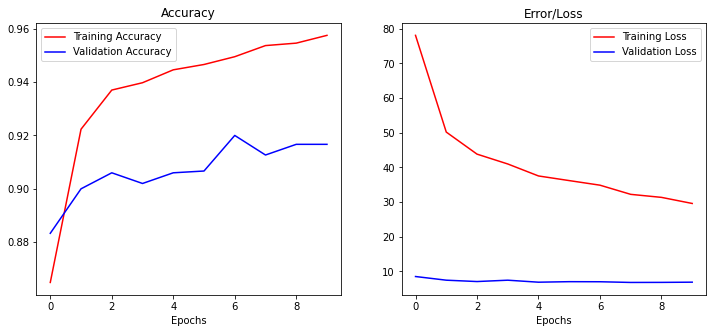

In [43]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 95 %
Training F1 score: 0.965799
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

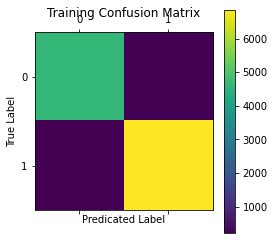

Testing Accuracy of the network on the 1500 images: 96 %
Testing F1 score: 0.974157
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

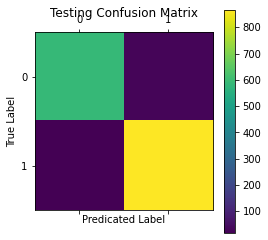

Validation Accuracy of the network on the 1500 images: 90 %
Validation F1 score: 0.921336
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

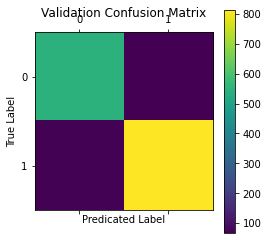

In [44]:
display_model_evaluation_parameters(model, trainloader, "Training")
display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")

### Evaluation: Load and Test my pre-trained RESNET18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<Figure size 432x288 with 0 Axes>

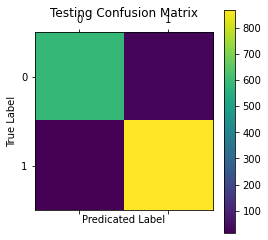

In [45]:
# Load the pretrained model from pytorch
PATH = saved_models_path + 'res18_FC_Only.pth'
model = models.resnet18(pretrained=False)
new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")

# TASK 2

## ---> Effect of Freezing Few CNN Layers and Replacing FC Layers in VGG-16

### Load Pre-Trained Model VGG-16

In [46]:
# Load the pretrained model from pytorch
model = models.vgg16(pretrained=True)
print(model)
print('Output Layer of VGG16 : ', model.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

# Freezing selective Convolution Layers and replace FC Layers

In [51]:
freeze_last_layers = 10
no_of_cnn_layers = len(list(model.features.parameters()))
i = 0
for param in model.features.parameters():
    i = i + 1
    if no_of_cnn_layers - freeze_last_layers <= 0:
      param.require_grad = False

new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss Function, Optimizer and Training

In [52]:
# Loss function and Optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    # counter = 0
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # counter = counter + 1
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_train_loss += loss.item()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct_count += (predicted == labels).sum().item()
        
        # if counter >= 5:
        #   break

    val_total = 0
    # counter = 0
    with torch.no_grad():
      for data in validationloader:  
          # counter = counter + 1        
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct_count += (predicted == labels).sum().item()

          loss = criterion(outputs, labels)   #----> compute loss
          running_val_loss += loss.item()

          # if counter >= 5:
          #   break;

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)

print('Finished Training')
print(training_loss)
print(training_accuracy)


0it [00:00, ?it/s]
1it [00:03,  3.26s/it]
2it [00:06,  3.23s/it]
3it [00:09,  3.21s/it]
4it [00:12,  3.23s/it]
5it [00:16,  3.22s/it]
6it [00:19,  3.26s/it]
7it [00:22,  3.24s/it]
8it [00:25,  3.21s/it]
9it [00:28,  3.22s/it]
10it [00:32,  3.21s/it]
11it [00:35,  3.22s/it]
12it [00:38,  3.21s/it]
13it [00:41,  3.20s/it]
14it [00:44,  3.20s/it]
15it [00:48,  3.21s/it]
16it [00:51,  3.20s/it]
17it [00:54,  3.21s/it]
18it [00:57,  3.20s/it]
19it [01:01,  3.28s/it]
20it [01:04,  3.25s/it]
21it [01:07,  3.25s/it]
22it [01:10,  3.23s/it]
23it [01:14,  3.22s/it]
24it [01:17,  3.20s/it]
25it [01:20,  3.21s/it]
26it [01:23,  3.22s/it]
27it [01:26,  3.21s/it]
28it [01:30,  3.20s/it]
29it [01:33,  3.20s/it]
30it [01:36,  3.19s/it]
31it [01:39,  3.20s/it]
32it [01:42,  3.21s/it]
33it [01:46,  3.21s/it]
34it [01:49,  3.21s/it]
35it [01:52,  3.21s/it]
36it [01:55,  3.21s/it]
37it [01:59,  3.27s/it]
38it [02:02,  3.25s/it]
39it [02:05,  3.25s/it]
40it [02:08,  3.23s/it]
41it [02:11,  3.23s/it]
42it 

Epoch = 0, accuracy = 0.907833, error = 60.217667



1it [00:03,  3.22s/it]
2it [00:06,  3.22s/it]
3it [00:09,  3.22s/it]
4it [00:12,  3.21s/it]
5it [00:16,  3.21s/it]
6it [00:19,  3.22s/it]
7it [00:22,  3.27s/it]
8it [00:25,  3.24s/it]
9it [00:29,  3.24s/it]
10it [00:32,  3.22s/it]
11it [00:35,  3.28s/it]
12it [00:38,  3.25s/it]
13it [00:42,  3.24s/it]
14it [00:45,  3.28s/it]
15it [00:48,  3.25s/it]
16it [00:51,  3.25s/it]
17it [00:55,  3.23s/it]
18it [00:58,  3.22s/it]
19it [01:01,  3.29s/it]
20it [01:04,  3.25s/it]
21it [01:08,  3.24s/it]
22it [01:11,  3.30s/it]
23it [01:14,  3.28s/it]
24it [01:17,  3.25s/it]
25it [01:21,  3.23s/it]
26it [01:24,  3.22s/it]
27it [01:27,  3.22s/it]
28it [01:30,  3.20s/it]
29it [01:33,  3.19s/it]
30it [01:37,  3.20s/it]
31it [01:40,  3.20s/it]
32it [01:43,  3.20s/it]
33it [01:46,  3.20s/it]
34it [01:49,  3.21s/it]
35it [01:53,  3.29s/it]
36it [01:56,  3.26s/it]
37it [01:59,  3.25s/it]
38it [02:02,  3.23s/it]
39it [02:06,  3.21s/it]
40it [02:09,  3.21s/it]
41it [02:12,  3.21s/it]
42it [02:15,  3.21s/it]


Epoch = 1, accuracy = 0.940250, error = 42.412933



1it [00:03,  3.20s/it]
2it [00:06,  3.20s/it]
3it [00:09,  3.20s/it]
4it [00:12,  3.19s/it]
5it [00:16,  3.21s/it]
6it [00:19,  3.22s/it]
7it [00:22,  3.21s/it]
8it [00:25,  3.21s/it]
9it [00:28,  3.20s/it]
10it [00:32,  3.19s/it]
11it [00:35,  3.20s/it]
12it [00:38,  3.19s/it]
13it [00:41,  3.19s/it]
14it [00:44,  3.20s/it]
15it [00:48,  3.20s/it]
16it [00:51,  3.21s/it]
17it [00:54,  3.21s/it]
18it [00:57,  3.21s/it]
19it [01:00,  3.19s/it]
20it [01:03,  3.19s/it]
21it [01:07,  3.20s/it]
22it [01:10,  3.19s/it]
23it [01:13,  3.20s/it]
24it [01:16,  3.21s/it]
25it [01:20,  3.21s/it]
26it [01:23,  3.21s/it]
27it [01:26,  3.20s/it]
28it [01:29,  3.20s/it]
29it [01:32,  3.20s/it]
30it [01:36,  3.20s/it]
31it [01:39,  3.20s/it]
32it [01:42,  3.19s/it]
33it [01:45,  3.20s/it]
34it [01:48,  3.20s/it]
35it [01:52,  3.20s/it]
36it [01:55,  3.19s/it]
37it [01:58,  3.19s/it]
38it [02:01,  3.18s/it]
39it [02:04,  3.18s/it]
40it [02:07,  3.18s/it]
41it [02:11,  3.19s/it]
42it [02:14,  3.19s/it]


Epoch = 2, accuracy = 0.944583, error = 39.779104



1it [00:03,  3.17s/it]
2it [00:06,  3.18s/it]
3it [00:09,  3.18s/it]
4it [00:12,  3.18s/it]
5it [00:15,  3.19s/it]
6it [00:19,  3.18s/it]
7it [00:22,  3.20s/it]
8it [00:25,  3.19s/it]
9it [00:28,  3.20s/it]
10it [00:31,  3.21s/it]
11it [00:35,  3.20s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.21s/it]
14it [00:44,  3.21s/it]
15it [00:47,  3.20s/it]
16it [00:51,  3.19s/it]
17it [00:54,  3.20s/it]
18it [00:57,  3.20s/it]
19it [01:00,  3.21s/it]
20it [01:03,  3.20s/it]
21it [01:07,  3.20s/it]
22it [01:10,  3.22s/it]
23it [01:13,  3.22s/it]
24it [01:16,  3.22s/it]
25it [01:20,  3.21s/it]
26it [01:23,  3.20s/it]
27it [01:26,  3.21s/it]
28it [01:29,  3.22s/it]
29it [01:32,  3.21s/it]
30it [01:36,  3.24s/it]
31it [01:39,  3.25s/it]
32it [01:42,  3.24s/it]
33it [01:45,  3.23s/it]
34it [01:49,  3.23s/it]
35it [01:52,  3.22s/it]
36it [01:55,  3.22s/it]
37it [01:58,  3.23s/it]
38it [02:01,  3.21s/it]
39it [02:05,  3.22s/it]
40it [02:08,  3.21s/it]
41it [02:11,  3.22s/it]
42it [02:14,  3.22s/it]


Epoch = 3, accuracy = 0.947833, error = 37.201368



1it [00:03,  3.19s/it]
2it [00:06,  3.18s/it]
3it [00:09,  3.18s/it]
4it [00:12,  3.18s/it]
5it [00:15,  3.18s/it]
6it [00:19,  3.18s/it]
7it [00:22,  3.19s/it]
8it [00:25,  3.20s/it]
9it [00:28,  3.20s/it]
10it [00:32,  3.25s/it]
11it [00:35,  3.23s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.21s/it]
14it [00:44,  3.21s/it]
15it [00:48,  3.20s/it]
16it [00:51,  3.19s/it]
17it [00:54,  3.20s/it]
18it [00:57,  3.21s/it]
19it [01:00,  3.21s/it]
20it [01:04,  3.20s/it]
21it [01:07,  3.20s/it]
22it [01:10,  3.19s/it]
23it [01:13,  3.18s/it]
24it [01:16,  3.18s/it]
25it [01:19,  3.19s/it]
26it [01:23,  3.20s/it]
27it [01:26,  3.20s/it]
28it [01:29,  3.20s/it]
29it [01:32,  3.20s/it]
30it [01:35,  3.20s/it]
31it [01:39,  3.20s/it]
32it [01:42,  3.19s/it]
33it [01:45,  3.20s/it]
34it [01:48,  3.19s/it]
35it [01:51,  3.19s/it]
36it [01:55,  3.19s/it]
37it [01:58,  3.27s/it]
38it [02:01,  3.23s/it]
39it [02:04,  3.23s/it]
40it [02:08,  3.22s/it]
41it [02:11,  3.24s/it]
42it [02:14,  3.22s/it]


Epoch = 4, accuracy = 0.952083, error = 33.640257



1it [00:03,  3.20s/it]
2it [00:06,  3.20s/it]
3it [00:09,  3.19s/it]
4it [00:12,  3.15s/it]
5it [00:15,  3.18s/it]
6it [00:19,  3.17s/it]
7it [00:22,  3.20s/it]
8it [00:25,  3.19s/it]
9it [00:28,  3.20s/it]
10it [00:31,  3.21s/it]
11it [00:35,  3.22s/it]
12it [00:38,  3.21s/it]
13it [00:41,  3.21s/it]
14it [00:44,  3.21s/it]
15it [00:47,  3.19s/it]
16it [00:51,  3.19s/it]
17it [00:54,  3.20s/it]
18it [00:57,  3.20s/it]
19it [01:00,  3.20s/it]
20it [01:03,  3.20s/it]
21it [01:07,  3.20s/it]
22it [01:10,  3.20s/it]
23it [01:13,  3.19s/it]
24it [01:16,  3.23s/it]
25it [01:20,  3.29s/it]
26it [01:23,  3.26s/it]
27it [01:26,  3.25s/it]
28it [01:29,  3.23s/it]
29it [01:33,  3.23s/it]
30it [01:36,  3.22s/it]
31it [01:39,  3.21s/it]
32it [01:42,  3.20s/it]
33it [01:45,  3.20s/it]
34it [01:48,  3.19s/it]
35it [01:52,  3.19s/it]
36it [01:55,  3.19s/it]
37it [01:58,  3.20s/it]
38it [02:01,  3.19s/it]
39it [02:04,  3.20s/it]
40it [02:08,  3.20s/it]
41it [02:11,  3.25s/it]
42it [02:14,  3.31s/it]


Epoch = 5, accuracy = 0.956500, error = 31.324049



1it [00:03,  3.23s/it]
2it [00:06,  3.21s/it]
3it [00:09,  3.21s/it]
4it [00:12,  3.20s/it]
5it [00:15,  3.21s/it]
6it [00:19,  3.21s/it]
7it [00:22,  3.21s/it]
8it [00:25,  3.21s/it]
9it [00:28,  3.20s/it]
10it [00:31,  3.19s/it]
11it [00:35,  3.20s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.20s/it]
14it [00:44,  3.18s/it]
15it [00:47,  3.19s/it]
16it [00:51,  3.19s/it]
17it [00:54,  3.20s/it]
18it [00:57,  3.28s/it]
19it [01:01,  3.35s/it]
20it [01:04,  3.30s/it]
21it [01:08,  3.35s/it]
22it [01:11,  3.31s/it]
23it [01:14,  3.30s/it]
24it [01:17,  3.27s/it]
25it [01:20,  3.25s/it]
26it [01:24,  3.23s/it]
27it [01:27,  3.24s/it]
28it [01:30,  3.23s/it]
29it [01:33,  3.23s/it]
30it [01:36,  3.21s/it]
31it [01:40,  3.23s/it]
32it [01:43,  3.19s/it]
33it [01:46,  3.18s/it]
34it [01:49,  3.15s/it]
35it [01:52,  3.14s/it]
36it [01:55,  3.11s/it]
37it [01:58,  3.10s/it]
38it [02:01,  3.09s/it]
39it [02:04,  3.08s/it]
40it [02:07,  3.06s/it]
41it [02:10,  3.06s/it]
42it [02:14,  3.06s/it]


Epoch = 6, accuracy = 0.956417, error = 30.731281



1it [00:03,  3.20s/it]
2it [00:06,  3.20s/it]
3it [00:09,  3.20s/it]
4it [00:12,  3.19s/it]
5it [00:15,  3.19s/it]
6it [00:19,  3.25s/it]
7it [00:22,  3.24s/it]
8it [00:25,  3.22s/it]
9it [00:28,  3.22s/it]
10it [00:32,  3.21s/it]
11it [00:35,  3.20s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.22s/it]
14it [00:44,  3.21s/it]
15it [00:48,  3.21s/it]
16it [00:51,  3.20s/it]
17it [00:54,  3.20s/it]
18it [00:57,  3.19s/it]
19it [01:01,  3.29s/it]
20it [01:04,  3.25s/it]
21it [01:07,  3.23s/it]
22it [01:10,  3.21s/it]
23it [01:13,  3.21s/it]
24it [01:17,  3.20s/it]
25it [01:20,  3.19s/it]
26it [01:23,  3.19s/it]
27it [01:26,  3.21s/it]
28it [01:29,  3.20s/it]
29it [01:33,  3.21s/it]
30it [01:36,  3.20s/it]
31it [01:39,  3.20s/it]
32it [01:42,  3.20s/it]
33it [01:45,  3.20s/it]
34it [01:49,  3.19s/it]
35it [01:52,  3.19s/it]
36it [01:55,  3.19s/it]
37it [01:58,  3.19s/it]
38it [02:01,  3.19s/it]
39it [02:05,  3.19s/it]
40it [02:08,  3.20s/it]
41it [02:11,  3.21s/it]
42it [02:14,  3.20s/it]


Epoch = 7, accuracy = 0.958250, error = 30.232082



1it [00:03,  3.18s/it]
2it [00:06,  3.18s/it]
3it [00:09,  3.18s/it]
4it [00:12,  3.18s/it]
5it [00:15,  3.20s/it]
6it [00:19,  3.20s/it]
7it [00:22,  3.21s/it]
8it [00:25,  3.21s/it]
9it [00:28,  3.20s/it]
10it [00:32,  3.26s/it]
11it [00:35,  3.24s/it]
12it [00:38,  3.23s/it]
13it [00:41,  3.21s/it]
14it [00:44,  3.21s/it]
15it [00:48,  3.21s/it]
16it [00:51,  3.21s/it]
17it [00:54,  3.22s/it]
18it [00:57,  3.22s/it]
19it [01:01,  3.24s/it]
20it [01:04,  3.22s/it]
21it [01:07,  3.22s/it]
22it [01:10,  3.21s/it]
23it [01:14,  3.29s/it]
24it [01:17,  3.26s/it]
25it [01:20,  3.25s/it]
26it [01:23,  3.23s/it]
27it [01:26,  3.22s/it]
28it [01:30,  3.21s/it]
29it [01:33,  3.21s/it]
30it [01:36,  3.21s/it]
31it [01:39,  3.22s/it]
32it [01:43,  3.22s/it]
33it [01:46,  3.22s/it]
34it [01:49,  3.22s/it]
35it [01:52,  3.21s/it]
36it [01:55,  3.21s/it]
37it [01:59,  3.22s/it]
38it [02:02,  3.21s/it]
39it [02:05,  3.21s/it]
40it [02:08,  3.20s/it]
41it [02:11,  3.20s/it]
42it [02:15,  3.21s/it]


Epoch = 8, accuracy = 0.963917, error = 26.893153



1it [00:03,  3.19s/it]
2it [00:06,  3.19s/it]
3it [00:09,  3.20s/it]
4it [00:12,  3.19s/it]
5it [00:15,  3.19s/it]
6it [00:19,  3.22s/it]
7it [00:22,  3.21s/it]
8it [00:25,  3.19s/it]
9it [00:28,  3.19s/it]
10it [00:32,  3.22s/it]
11it [00:35,  3.22s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.20s/it]
14it [00:44,  3.20s/it]
15it [00:48,  3.20s/it]
16it [00:51,  3.20s/it]
17it [00:54,  3.20s/it]
18it [00:57,  3.19s/it]
19it [01:00,  3.19s/it]
20it [01:03,  3.19s/it]
21it [01:07,  3.19s/it]
22it [01:10,  3.19s/it]
23it [01:13,  3.20s/it]
24it [01:16,  3.19s/it]
25it [01:19,  3.20s/it]
26it [01:23,  3.25s/it]
27it [01:26,  3.23s/it]
28it [01:29,  3.23s/it]
29it [01:32,  3.22s/it]
30it [01:36,  3.25s/it]
31it [01:39,  3.24s/it]
32it [01:42,  3.23s/it]
33it [01:45,  3.23s/it]
34it [01:49,  3.23s/it]
35it [01:52,  3.23s/it]
36it [01:55,  3.21s/it]
37it [01:58,  3.21s/it]
38it [02:01,  3.20s/it]
39it [02:05,  3.20s/it]
40it [02:08,  3.20s/it]
41it [02:11,  3.22s/it]
42it [02:14,  3.21s/it]


Epoch = 9, accuracy = 0.966000, error = 25.753742
Finished Training
[60.21766744181514, 42.41293280571699, 39.77910356968641, 37.201368264853954, 33.64025703072548, 31.324048785492778, 30.73128111800179, 30.232082319445908, 26.893152683973312, 25.75374222267419]
[0.9078333333333334, 0.94025, 0.9445833333333333, 0.9478333333333333, 0.9520833333333333, 0.9565, 0.9564166666666667, 0.95825, 0.9639166666666666, 0.966]


### Save the Model VGG16

In [0]:
torch.save(model.state_dict(), saved_models_path + 'vgg16_partial.pth')

### Accuracy and Loss Curves during Training

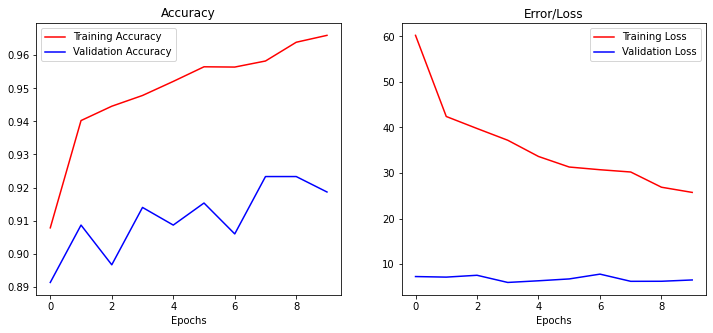

In [55]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 96 %
Training F1 score: 0.972687
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

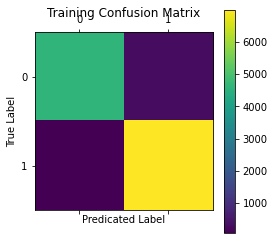

Testing Accuracy of the network on the 1500 images: 97 %
Testing F1 score: 0.977654
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

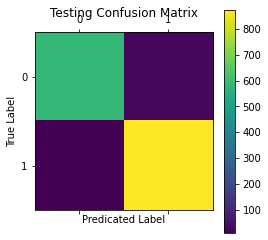

Validation Accuracy of the network on the 1500 images: 91 %
Validation F1 score: 0.931538
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

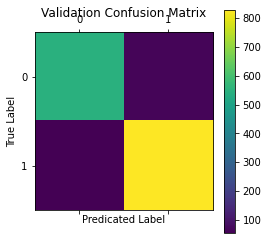

In [56]:
display_model_evaluation_parameters(model, trainloader, "Training")
display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")

### Evaluation: Load and Test my pre-trained VGG-16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<Figure size 432x288 with 0 Axes>

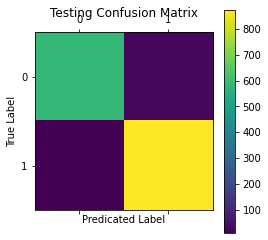

In [54]:
# Load the pretrained model from pytorch
PATH = saved_models_path + 'vgg16_partial.pth'
model = models.vgg16(pretrained=False)
new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")

## ---> Effect of Un-Freezing all CNN Layers and Replacing FC Layers in VGG-16

### Load pre-trained VGG-16

In [9]:
# Load the pretrained model from pytorch
model = models.vgg16(pretrained=True)
print(model)
print('Output Layer of VGG16 : ', model.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### Un-Freezing all the Convolution Layers and replacing FC Layers

In [58]:
new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss Function, Optimizer and Training

In [59]:
# Loss function and Optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    # counter = 0
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # counter = counter + 1
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_train_loss += loss.item()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct_count += (predicted == labels).sum().item()
        
        # if counter >= 5:
        #   break

    val_total = 0
    # counter = 0
    with torch.no_grad():
      for data in validationloader:  
          # counter = counter + 1        
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct_count += (predicted == labels).sum().item()

          loss = criterion(outputs, labels)   #----> compute loss
          running_val_loss += loss.item()

          # if counter >= 5:
          #   break;

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)

print('Finished Training')
print(training_loss)
print(training_accuracy)


0it [00:00, ?it/s]
1it [00:03,  3.23s/it]
2it [00:06,  3.24s/it]
3it [00:09,  3.24s/it]
4it [00:12,  3.22s/it]
5it [00:16,  3.23s/it]
6it [00:19,  3.22s/it]
7it [00:22,  3.28s/it]
8it [00:25,  3.26s/it]
9it [00:29,  3.24s/it]
10it [00:32,  3.29s/it]
11it [00:35,  3.25s/it]
12it [00:39,  3.25s/it]
13it [00:42,  3.23s/it]
14it [00:45,  3.26s/it]
15it [00:48,  3.24s/it]
16it [00:51,  3.23s/it]
17it [00:55,  3.22s/it]
18it [00:58,  3.21s/it]
19it [01:01,  3.21s/it]
20it [01:04,  3.21s/it]
21it [01:07,  3.20s/it]
22it [01:11,  3.22s/it]
23it [01:14,  3.21s/it]
24it [01:17,  3.18s/it]
25it [01:20,  3.19s/it]
26it [01:23,  3.19s/it]
27it [01:27,  3.20s/it]
28it [01:30,  3.19s/it]
29it [01:33,  3.19s/it]
30it [01:36,  3.20s/it]
31it [01:39,  3.20s/it]
32it [01:43,  3.21s/it]
33it [01:46,  3.19s/it]
34it [01:49,  3.20s/it]
35it [01:52,  3.20s/it]
36it [01:55,  3.20s/it]
37it [01:59,  3.20s/it]
38it [02:02,  3.20s/it]
39it [02:05,  3.19s/it]
40it [02:08,  3.20s/it]
41it [02:11,  3.20s/it]
42it 

Epoch = 0, accuracy = 0.895833, error = 64.094621



1it [00:03,  3.20s/it]
2it [00:06,  3.20s/it]
3it [00:09,  3.20s/it]
4it [00:12,  3.20s/it]
5it [00:15,  3.19s/it]
6it [00:19,  3.20s/it]
7it [00:22,  3.18s/it]
8it [00:25,  3.20s/it]
9it [00:28,  3.20s/it]
10it [00:31,  3.20s/it]
11it [00:35,  3.19s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.20s/it]
14it [00:44,  3.19s/it]
15it [00:47,  3.19s/it]
16it [00:51,  3.20s/it]
17it [00:54,  3.19s/it]
18it [00:57,  3.23s/it]
19it [01:00,  3.23s/it]
20it [01:04,  3.27s/it]
21it [01:07,  3.26s/it]
22it [01:10,  3.26s/it]
23it [01:13,  3.24s/it]
24it [01:17,  3.26s/it]
25it [01:20,  3.25s/it]
26it [01:23,  3.23s/it]
27it [01:26,  3.24s/it]
28it [01:30,  3.23s/it]
29it [01:33,  3.22s/it]
30it [01:36,  3.21s/it]
31it [01:39,  3.25s/it]
32it [01:42,  3.23s/it]
33it [01:46,  3.22s/it]
34it [01:49,  3.21s/it]
35it [01:52,  3.21s/it]
36it [01:55,  3.20s/it]
37it [01:58,  3.19s/it]
38it [02:02,  3.20s/it]
39it [02:05,  3.23s/it]
40it [02:08,  3.24s/it]
41it [02:11,  3.22s/it]
42it [02:15,  3.21s/it]


Epoch = 1, accuracy = 0.934667, error = 43.709225



1it [00:03,  3.20s/it]
2it [00:06,  3.27s/it]
3it [00:09,  3.27s/it]
4it [00:13,  3.26s/it]
5it [00:16,  3.24s/it]
6it [00:19,  3.24s/it]
7it [00:22,  3.22s/it]
8it [00:25,  3.22s/it]
9it [00:29,  3.23s/it]
10it [00:32,  3.22s/it]
11it [00:35,  3.23s/it]
12it [00:38,  3.21s/it]
13it [00:42,  3.26s/it]
14it [00:45,  3.24s/it]
15it [00:48,  3.22s/it]
16it [00:51,  3.22s/it]
17it [00:54,  3.22s/it]
18it [00:58,  3.22s/it]
19it [01:01,  3.21s/it]
20it [01:04,  3.21s/it]
21it [01:07,  3.22s/it]
22it [01:11,  3.26s/it]
23it [01:14,  3.24s/it]
24it [01:17,  3.22s/it]
25it [01:20,  3.22s/it]
26it [01:24,  3.22s/it]
27it [01:27,  3.23s/it]
28it [01:30,  3.21s/it]
29it [01:33,  3.21s/it]
30it [01:36,  3.21s/it]
31it [01:40,  3.19s/it]
32it [01:43,  3.19s/it]
33it [01:46,  3.19s/it]
34it [01:49,  3.20s/it]
35it [01:53,  3.29s/it]
36it [01:56,  3.27s/it]
37it [01:59,  3.25s/it]
38it [02:02,  3.23s/it]
39it [02:06,  3.30s/it]
40it [02:09,  3.27s/it]
41it [02:12,  3.25s/it]
42it [02:16,  3.33s/it]


Epoch = 2, accuracy = 0.944083, error = 40.369555



1it [00:03,  3.19s/it]
2it [00:06,  3.19s/it]
3it [00:09,  3.21s/it]
4it [00:12,  3.22s/it]
5it [00:16,  3.22s/it]
6it [00:19,  3.22s/it]
7it [00:22,  3.21s/it]
8it [00:25,  3.21s/it]
9it [00:28,  3.20s/it]
10it [00:32,  3.20s/it]
11it [00:35,  3.20s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.21s/it]
14it [00:45,  3.32s/it]
15it [00:48,  3.30s/it]
16it [00:51,  3.27s/it]
17it [00:54,  3.26s/it]
18it [00:58,  3.24s/it]
19it [01:01,  3.29s/it]
20it [01:04,  3.26s/it]
21it [01:08,  3.25s/it]
22it [01:11,  3.25s/it]
23it [01:14,  3.23s/it]
24it [01:17,  3.27s/it]
25it [01:20,  3.24s/it]
26it [01:24,  3.23s/it]
27it [01:27,  3.22s/it]
28it [01:30,  3.22s/it]
29it [01:33,  3.22s/it]
30it [01:37,  3.21s/it]
31it [01:40,  3.22s/it]
32it [01:43,  3.22s/it]
33it [01:46,  3.31s/it]
34it [01:50,  3.28s/it]
35it [01:53,  3.25s/it]
36it [01:56,  3.24s/it]
37it [01:59,  3.23s/it]
38it [02:02,  3.22s/it]
39it [02:06,  3.21s/it]
40it [02:09,  3.21s/it]
41it [02:12,  3.21s/it]
42it [02:15,  3.21s/it]


Epoch = 3, accuracy = 0.949583, error = 35.734083



1it [00:03,  3.21s/it]
2it [00:06,  3.21s/it]
3it [00:09,  3.21s/it]
4it [00:12,  3.21s/it]
5it [00:16,  3.21s/it]
6it [00:19,  3.21s/it]
7it [00:22,  3.21s/it]
8it [00:25,  3.21s/it]
9it [00:28,  3.20s/it]
10it [00:32,  3.21s/it]
11it [00:35,  3.20s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.20s/it]
14it [00:44,  3.21s/it]
15it [00:48,  3.20s/it]
16it [00:51,  3.21s/it]
17it [00:54,  3.21s/it]
18it [00:58,  3.30s/it]
19it [01:01,  3.27s/it]
20it [01:04,  3.25s/it]
21it [01:07,  3.24s/it]
22it [01:10,  3.23s/it]
23it [01:14,  3.23s/it]
24it [01:17,  3.22s/it]
25it [01:20,  3.22s/it]
26it [01:23,  3.22s/it]
27it [01:26,  3.21s/it]
28it [01:30,  3.21s/it]
29it [01:33,  3.21s/it]
30it [01:36,  3.21s/it]
31it [01:39,  3.20s/it]
32it [01:42,  3.20s/it]
33it [01:46,  3.20s/it]
34it [01:49,  3.22s/it]
35it [01:52,  3.21s/it]
36it [01:55,  3.23s/it]
37it [01:59,  3.27s/it]
38it [02:02,  3.26s/it]
39it [02:05,  3.23s/it]
40it [02:08,  3.24s/it]
41it [02:12,  3.23s/it]
42it [02:15,  3.23s/it]


Epoch = 4, accuracy = 0.951250, error = 34.279199



1it [00:03,  3.17s/it]
2it [00:06,  3.17s/it]
3it [00:09,  3.16s/it]
4it [00:12,  3.16s/it]
5it [00:15,  3.16s/it]
6it [00:19,  3.22s/it]
7it [00:22,  3.20s/it]
8it [00:25,  3.21s/it]
9it [00:29,  3.31s/it]
10it [00:32,  3.27s/it]
11it [00:35,  3.24s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.18s/it]
14it [00:44,  3.18s/it]
15it [00:48,  3.18s/it]
16it [00:51,  3.17s/it]
17it [00:54,  3.17s/it]
18it [00:57,  3.17s/it]
19it [01:00,  3.17s/it]
20it [01:04,  3.22s/it]
21it [01:07,  3.20s/it]
22it [01:10,  3.19s/it]
23it [01:13,  3.19s/it]
24it [01:16,  3.19s/it]
25it [01:19,  3.18s/it]
26it [01:23,  3.17s/it]
27it [01:26,  3.17s/it]
28it [01:29,  3.17s/it]
29it [01:32,  3.17s/it]
30it [01:35,  3.16s/it]
31it [01:38,  3.16s/it]
32it [01:42,  3.17s/it]
33it [01:45,  3.16s/it]
34it [01:48,  3.16s/it]
35it [01:51,  3.16s/it]
36it [01:54,  3.16s/it]
37it [01:57,  3.16s/it]
38it [02:00,  3.17s/it]
39it [02:04,  3.17s/it]
40it [02:07,  3.18s/it]
41it [02:10,  3.19s/it]
42it [02:13,  3.18s/it]


Epoch = 5, accuracy = 0.957250, error = 32.745191



1it [00:03,  3.18s/it]
2it [00:06,  3.18s/it]
3it [00:09,  3.17s/it]
4it [00:12,  3.17s/it]
5it [00:15,  3.17s/it]
6it [00:19,  3.17s/it]
7it [00:22,  3.19s/it]
8it [00:25,  3.26s/it]
9it [00:28,  3.24s/it]
10it [00:32,  3.22s/it]
11it [00:35,  3.22s/it]
12it [00:38,  3.21s/it]
13it [00:41,  3.20s/it]
14it [00:44,  3.19s/it]
15it [00:47,  3.18s/it]
16it [00:51,  3.17s/it]
17it [00:54,  3.17s/it]
18it [00:57,  3.22s/it]
19it [01:00,  3.20s/it]
20it [01:03,  3.20s/it]
21it [01:07,  3.19s/it]
22it [01:10,  3.18s/it]
23it [01:13,  3.18s/it]
24it [01:16,  3.18s/it]
25it [01:19,  3.22s/it]
26it [01:23,  3.20s/it]
27it [01:26,  3.20s/it]
28it [01:29,  3.19s/it]
29it [01:32,  3.20s/it]
30it [01:35,  3.19s/it]
31it [01:39,  3.18s/it]
32it [01:42,  3.18s/it]
33it [01:45,  3.26s/it]
34it [01:48,  3.23s/it]
35it [01:51,  3.22s/it]
36it [01:55,  3.20s/it]
37it [01:58,  3.19s/it]
38it [02:01,  3.20s/it]
39it [02:04,  3.18s/it]
40it [02:07,  3.19s/it]
41it [02:11,  3.19s/it]
42it [02:14,  3.22s/it]


Epoch = 6, accuracy = 0.956417, error = 31.214803



1it [00:03,  3.15s/it]
2it [00:06,  3.26s/it]
3it [00:09,  3.23s/it]
4it [00:13,  3.21s/it]
5it [00:16,  3.19s/it]
6it [00:19,  3.18s/it]
7it [00:22,  3.17s/it]
8it [00:25,  3.18s/it]
9it [00:28,  3.21s/it]
10it [00:32,  3.20s/it]
11it [00:35,  3.19s/it]
12it [00:38,  3.20s/it]
13it [00:41,  3.19s/it]
14it [00:44,  3.18s/it]
15it [00:47,  3.17s/it]
16it [00:51,  3.17s/it]
17it [00:54,  3.23s/it]
18it [00:57,  3.22s/it]
19it [01:00,  3.20s/it]
20it [01:04,  3.19s/it]
21it [01:07,  3.20s/it]
22it [01:10,  3.19s/it]
23it [01:13,  3.18s/it]
24it [01:16,  3.18s/it]
25it [01:19,  3.17s/it]
26it [01:23,  3.17s/it]
27it [01:26,  3.21s/it]
28it [01:29,  3.20s/it]
29it [01:32,  3.19s/it]
30it [01:35,  3.18s/it]
31it [01:39,  3.18s/it]
32it [01:42,  3.18s/it]
33it [01:45,  3.16s/it]
34it [01:48,  3.19s/it]
35it [01:51,  3.18s/it]
36it [01:54,  3.17s/it]
37it [01:58,  3.17s/it]
38it [02:01,  3.17s/it]
39it [02:04,  3.16s/it]
40it [02:07,  3.17s/it]
41it [02:10,  3.17s/it]
42it [02:13,  3.17s/it]


Epoch = 7, accuracy = 0.962500, error = 27.888313



1it [00:03,  3.44s/it]
2it [00:06,  3.43s/it]
3it [00:09,  3.34s/it]
4it [00:13,  3.29s/it]
5it [00:16,  3.25s/it]
6it [00:19,  3.23s/it]
7it [00:22,  3.25s/it]
8it [00:25,  3.22s/it]
9it [00:29,  3.21s/it]
10it [00:32,  3.20s/it]
11it [00:35,  3.18s/it]
12it [00:38,  3.18s/it]
13it [00:41,  3.18s/it]
14it [00:44,  3.18s/it]
15it [00:48,  3.18s/it]
16it [00:51,  3.18s/it]
17it [00:54,  3.18s/it]
18it [00:57,  3.19s/it]
19it [01:00,  3.18s/it]
20it [01:04,  3.17s/it]
21it [01:07,  3.17s/it]
22it [01:10,  3.19s/it]
23it [01:13,  3.18s/it]
24it [01:16,  3.18s/it]
25it [01:19,  3.18s/it]
26it [01:23,  3.18s/it]
27it [01:26,  3.18s/it]
28it [01:29,  3.28s/it]
29it [01:32,  3.25s/it]
30it [01:36,  3.22s/it]
31it [01:39,  3.20s/it]
32it [01:42,  3.19s/it]
33it [01:45,  3.18s/it]
34it [01:48,  3.18s/it]
35it [01:52,  3.21s/it]
36it [01:55,  3.21s/it]
37it [01:58,  3.20s/it]
38it [02:01,  3.25s/it]
39it [02:05,  3.23s/it]
40it [02:08,  3.21s/it]
41it [02:11,  3.20s/it]
42it [02:14,  3.19s/it]


Epoch = 8, accuracy = 0.963750, error = 27.027573



1it [00:03,  3.14s/it]
2it [00:06,  3.16s/it]
3it [00:09,  3.16s/it]
4it [00:12,  3.16s/it]
5it [00:15,  3.16s/it]
6it [00:19,  3.18s/it]
7it [00:22,  3.22s/it]
8it [00:25,  3.20s/it]
9it [00:28,  3.18s/it]
10it [00:31,  3.19s/it]
11it [00:35,  3.18s/it]
12it [00:38,  3.18s/it]
13it [00:41,  3.18s/it]
14it [00:44,  3.23s/it]
15it [00:47,  3.21s/it]
16it [00:51,  3.20s/it]
17it [00:54,  3.19s/it]
18it [00:57,  3.28s/it]
19it [01:00,  3.24s/it]
20it [01:03,  3.21s/it]
21it [01:07,  3.19s/it]
22it [01:10,  3.19s/it]
23it [01:13,  3.17s/it]
24it [01:16,  3.17s/it]
25it [01:19,  3.16s/it]
26it [01:22,  3.17s/it]
27it [01:26,  3.17s/it]
28it [01:29,  3.17s/it]
29it [01:32,  3.17s/it]
30it [01:35,  3.16s/it]
31it [01:38,  3.16s/it]
32it [01:41,  3.17s/it]
33it [01:45,  3.17s/it]
34it [01:48,  3.17s/it]
35it [01:51,  3.17s/it]
36it [01:54,  3.17s/it]
37it [01:57,  3.17s/it]
38it [02:00,  3.17s/it]
39it [02:04,  3.16s/it]
40it [02:07,  3.21s/it]
41it [02:10,  3.19s/it]
42it [02:13,  3.19s/it]


Epoch = 9, accuracy = 0.968250, error = 24.664085
Finished Training
[64.09462144970894, 43.709225200116634, 40.36955490335822, 35.734082750976086, 34.2791988607496, 32.74519124161452, 31.214803193695843, 27.8883125949651, 27.027573053725064, 24.664084957912564]
[0.8958333333333334, 0.9346666666666666, 0.9440833333333334, 0.9495833333333333, 0.95125, 0.95725, 0.9564166666666667, 0.9625, 0.96375, 0.96825]


### Save the Model VGG-16

In [0]:
torch.save(model.state_dict(), saved_models_path + 'vgg16_entire.pth')

### Accuracy and Loss Curves during Training

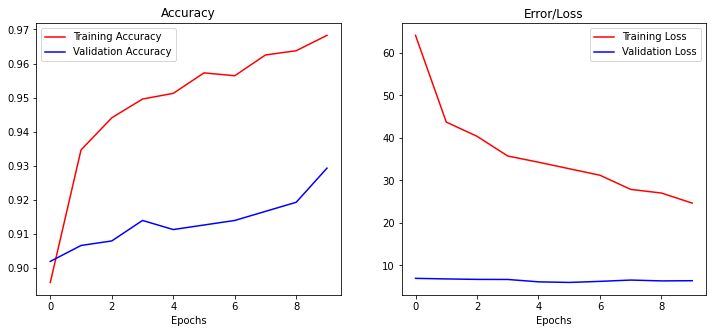

In [61]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 96 %
Training F1 score: 0.971625
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

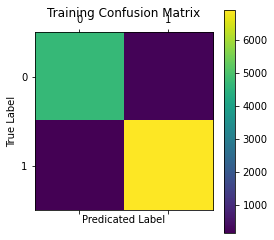

Testing Accuracy of the network on the 1500 images: 97 %
Testing F1 score: 0.974762
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

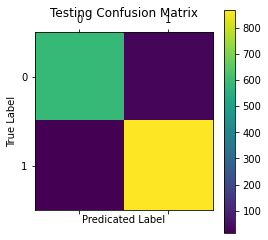

Validation Accuracy of the network on the 1500 images: 92 %
Validation F1 score: 0.934857
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

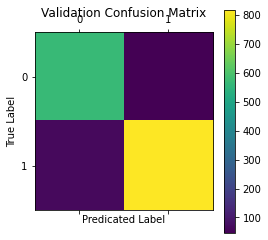

In [62]:
display_model_evaluation_parameters(model, trainloader, "Training")
display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")

### Evaluation: Load and Test my pre-trained VGG-16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<Figure size 432x288 with 0 Axes>

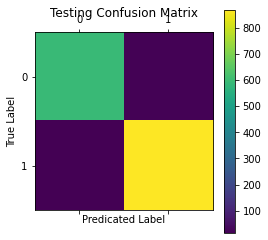

In [64]:
# Load the pretrained model from pytorch
PATH = saved_models_path + 'vgg16_entire.pth'
model = models.vgg16(pretrained=False)
new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")

 ## ---> Effect of Freezing Few CNN Layers and Replacing FC Layers in RESNET18

### Load pre-trained RESNET18

In [14]:
# Load the pretrained model from pytorch
model = models.resnet18(pretrained=True)
print(model)
print('Output Layer of RESNET18 : ', model.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freezing selective Convolution Layers and replace FC Layers

In [15]:
for param in model.conv1.parameters():
    param.require_grad = False
for param in model.bn1.parameters():
    param.require_grad = False
for param in model.relu.parameters():
    param.require_grad = False
for param in model.maxpool.parameters():
    param.require_grad = False
for param in model.layer1.parameters():
    param.require_grad = False
for param in model.layer2.parameters():
    param.require_grad = False
# for param in model.layer3.parameters():
#     param.require_grad = False
# for param in model.layer4.parameters():
#     param.require_grad = False
# for param in model.avgpool.parameters():
#     param.require_grad = False

new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss Function, Optimizer and Training

In [16]:
# Loss function and Optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_train_loss += loss.item()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct_count += (predicted == labels).sum().item()
        
    val_total = 0
    with torch.no_grad():
      for data in validationloader:     
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct_count += (predicted == labels).sum().item()

          loss = criterion(outputs, labels)   #----> compute loss
          running_val_loss += loss.item()

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)

print('Finished Training')
print(training_loss)
print(training_accuracy)

240it [05:30,  1.38s/it]
0it [00:00, ?it/s]

Epoch = 0, accuracy = 0.870833, error = 76.546386


240it [05:09,  1.29s/it]
0it [00:00, ?it/s]

Epoch = 1, accuracy = 0.924500, error = 50.657215


240it [05:00,  1.25s/it]
0it [00:00, ?it/s]

Epoch = 2, accuracy = 0.935917, error = 42.639047


240it [04:58,  1.24s/it]
0it [00:00, ?it/s]

Epoch = 3, accuracy = 0.941333, error = 39.482149


240it [04:57,  1.24s/it]
0it [00:00, ?it/s]

Epoch = 4, accuracy = 0.943583, error = 38.208244


240it [04:57,  1.24s/it]
0it [00:00, ?it/s]

Epoch = 5, accuracy = 0.946667, error = 35.751148


240it [05:01,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 6, accuracy = 0.950750, error = 33.327876


240it [05:03,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 7, accuracy = 0.953917, error = 31.642041


240it [05:02,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 8, accuracy = 0.957250, error = 30.073682


240it [04:57,  1.24s/it]


Epoch = 9, accuracy = 0.959333, error = 29.103356
Finished Training
[76.54638580232859, 50.65721474587917, 42.63904733210802, 39.48214886523783, 38.20824368670583, 35.75114794075489, 33.32787596061826, 31.642040682956576, 30.073681605048478, 29.10335630737245]
[0.8708333333333333, 0.9245, 0.9359166666666666, 0.9413333333333334, 0.9435833333333333, 0.9466666666666667, 0.95075, 0.9539166666666666, 0.95725, 0.9593333333333334]


### Save the Model RESNET18

In [0]:
torch.save(model.state_dict(), saved_models_path + 'res18_partial.pth')

### Accuracy and Loss Curves during Training

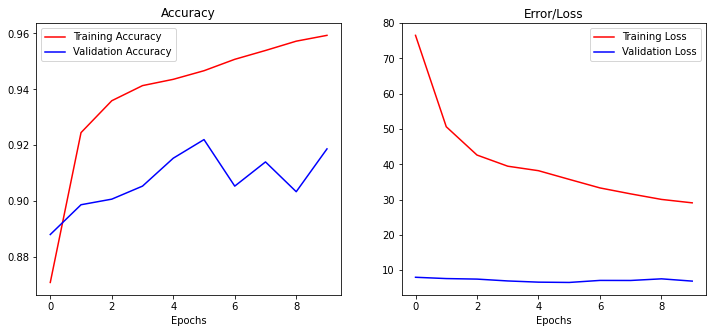

In [18]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 96 %
Training F1 score: 0.967387
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

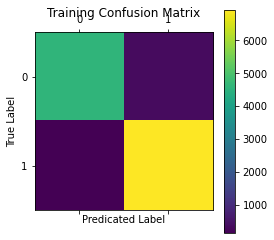

Testing Accuracy of the network on the 1500 images: 96 %
Testing F1 score: 0.973392
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

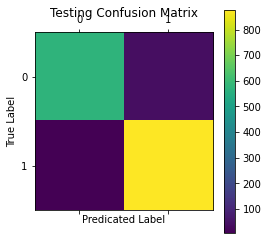

Validation Accuracy of the network on the 1500 images: 91 %
Validation F1 score: 0.932522
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

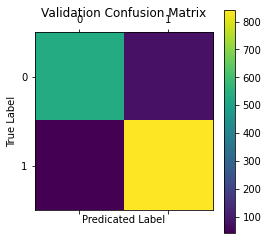

In [19]:
display_model_evaluation_parameters(model, trainloader, "Training")
display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")

### Evaluation: Load and Test my pre-trained RESNET18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<Figure size 432x288 with 0 Axes>

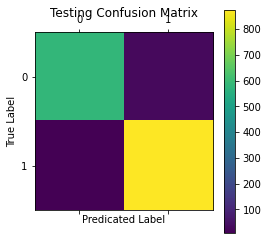

In [20]:
# Load the pretrained model from pytorch
PATH = saved_models_path + 'res18_partial.pth'
model = models.resnet18(pretrained=False)
new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")

## ---> Effect of Un-Freezing all CNN Layers and Replacing FC Layers in RESNET18

### Load pre-trained RESNET18

In [21]:
# Load the pretrained model from pytorch
model = models.resnet18(pretrained=True)
print(model)
print('Output Layer of RESNET18 : ', model.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Un-Freezing all the Convolution Layers and replacing FC Layers

In [22]:
new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss Function, Optimizer and Training

In [23]:
# Loss function and Optimizer
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_train_loss += loss.item()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct_count += (predicted == labels).sum().item()
        
    val_total = 0
    with torch.no_grad():
      for data in validationloader:     
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct_count += (predicted == labels).sum().item()

          loss = criterion(outputs, labels)   #----> compute loss
          running_val_loss += loss.item()

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)

print('Finished Training')
print(training_loss)
print(training_accuracy)

240it [05:01,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 0, accuracy = 0.861750, error = 80.243306


240it [05:07,  1.28s/it]
0it [00:00, ?it/s]

Epoch = 1, accuracy = 0.924417, error = 49.619806


240it [05:05,  1.27s/it]
0it [00:00, ?it/s]

Epoch = 2, accuracy = 0.933750, error = 44.761150


240it [05:07,  1.28s/it]
0it [00:00, ?it/s]

Epoch = 3, accuracy = 0.940583, error = 40.482924


240it [05:04,  1.27s/it]
0it [00:00, ?it/s]

Epoch = 4, accuracy = 0.945000, error = 38.091919


240it [05:02,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 5, accuracy = 0.948417, error = 35.692303


240it [05:10,  1.29s/it]
0it [00:00, ?it/s]

Epoch = 6, accuracy = 0.950583, error = 33.821337


240it [05:03,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 7, accuracy = 0.952917, error = 32.270104


240it [04:59,  1.25s/it]
0it [00:00, ?it/s]

Epoch = 8, accuracy = 0.955583, error = 31.660909


240it [04:59,  1.25s/it]


Epoch = 9, accuracy = 0.957500, error = 29.530279
Finished Training
[80.24330607801676, 49.619806468486786, 44.76115045696497, 40.48292442783713, 38.09191857278347, 35.69230338931084, 33.821336871013045, 32.27010354399681, 31.66090949997306, 29.530279399827123]
[0.86175, 0.9244166666666667, 0.93375, 0.9405833333333333, 0.945, 0.9484166666666667, 0.9505833333333333, 0.9529166666666666, 0.9555833333333333, 0.9575]


### Save the Model RESNET18

In [0]:
torch.save(model.state_dict(), saved_models_path + 'res18_entire.pth')

### Accuracy and Loss Curves during Training

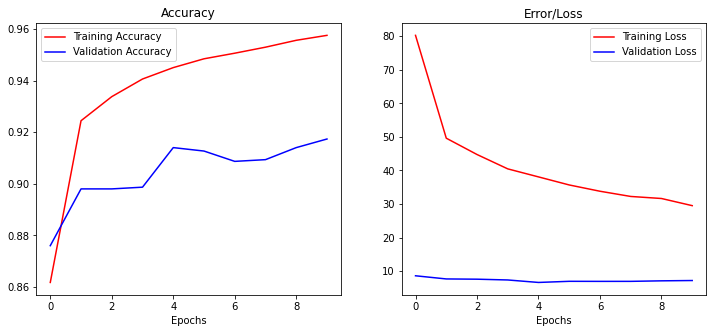

In [25]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 95 %
Training F1 score: 0.963847
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

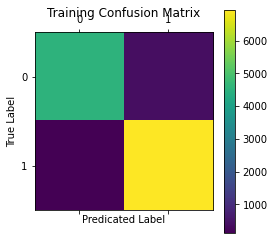

Testing Accuracy of the network on the 1500 images: 96 %
Testing F1 score: 0.970033
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

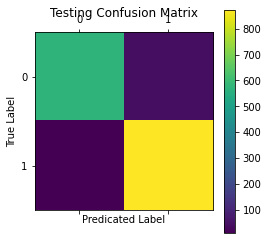

Validation Accuracy of the network on the 1500 images: 90 %
Validation F1 score: 0.921038
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

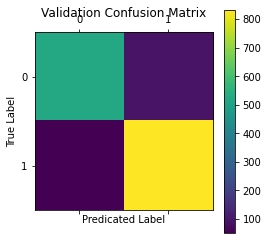

In [26]:
display_model_evaluation_parameters(model, trainloader, "Training")
display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")

### Evaluation: Load and Test my pre-trained RESNET18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<Figure size 432x288 with 0 Axes>

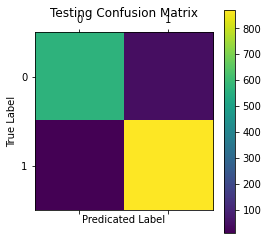

In [27]:
# Load the pretrained model from pytorch
PATH = save_models_path + 'res18_entire.pth'
model = models.resnet18(pretrained=False)
new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")